In [325]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime
import json
import os
import folium
import warnings
warnings.filterwarnings('ignore')

# from geopy.geocoders import Nominatim

In [326]:
import sys
import os

sys.path.insert(0, 'file/carnevale.ipynb')
from functions import haversine_distance,euclidean_distance,haversine_distance_normalized,euclidean_distance_normalized,custom_distance, find_csv_files, choose_dataset

In [327]:
dr = '/Users/matteograzioso/Desktop/Università/Tirocinio/Tirocinio-Progetto-MASTER/'
dr_data = '/Users/matteograzioso/Desktop/Università/Tirocinio/Tirocinio-Progetto-MASTER/data/processed/csvPuliti/'
#stops = pd.read_csv(dr+'gtfs/'+'stops.txt', sep=',')
#stops.rename(columns={"stop_id": "FERMATA","stop_name": "NOME_FERMATA", "stop_lat": "LATITUDE", "stop_lon": "LONGITUDE"}, inplace=True)
#cols = ['FERMATA','NOME_FERMATA','LATITUDE','LONGITUDE']
#stops = stops[cols]
#stops.to_csv(dr+'gtfs/'+ 'stops.csv',index=False)

#stops = pd.read_csv(dr+'gtfs/'+ 'stops.csv')
#print(f'stops.shape: {stops.shape}')
#stops

In [328]:
def find_csv_files(folder_path: str) -> list:
    """
        This function returns a list of all the csv files in the specified folder.
        :param folder_path: the path of the folder
        :return: a list of all the csv files in the specified folder
    """

    csv_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # File extension is .txt or .csv
            if file.endswith(".csv"):
                csv_files.append(os.path.join(root, file))
    # Sort the list of txt files in alphabetical order
    csv_files.sort()

    return csv_files

def choose_dataset(txt_files: list) -> str:
    """
        This function returns the path of the txt file chosen by the user.
        :param txt_files: the list of txt files
        :return: the path of the txt file chosen by the user
    """
    if not txt_files:
        print("No TXT file found.")
        return "None"
    if len(txt_files) == 1:
        print("The following file was found:")
    else:
        print("The following files were found:")
    for i, file_path in enumerate(txt_files):
        print(f"{i+1}. {file_path}")
    while True:
        choice = input("Enter the number corresponding to the dataset you wish to use (0 to exit): ")
        if not choice.isdigit():
            print("Enter a valid number.")
            continue
        choice = int(choice)
        if choice == 0:
            return "None"
        if choice < 1 or choice > len(txt_files):
            print("Enter a valid number.")
            continue
        return txt_files[choice - 1]
    

In [329]:
# Open the dataset that has also the geo coordinates
# Find all txt files in the data folder
csv_file = find_csv_files('/Users/matteograzioso/Desktop/Università/Tirocinio/Tirocinio-Progetto-MASTER/data/processed/csvPuliti/')

print("Select a dataset with geo coordinates from the list:")

# Choose a dataset from the list of txt files
selected_dataset = choose_dataset(csv_file)

if selected_dataset:
    print(f"You selected the dataset {selected_dataset}")
else:
    print("No dataset selected.")

path  = selected_dataset

Select a dataset with geo coordinates from the list:
The following files were found:
1. /Users/matteograzioso/Desktop/Università/Tirocinio/Tirocinio-Progetto-MASTER/data/processed/csvPuliti/dataset_cleaned_tempesportazioneCompleta.csv
2. /Users/matteograzioso/Desktop/Università/Tirocinio/Tirocinio-Progetto-MASTER/data/processed/csvPuliti/dataset_cleaned_tempesportazioneCompleta_after.csv
3. /Users/matteograzioso/Desktop/Università/Tirocinio/Tirocinio-Progetto-MASTER/data/processed/csvPuliti/dataset_cleaned_tempesportazioneCompleta_before.csv
4. /Users/matteograzioso/Desktop/Università/Tirocinio/Tirocinio-Progetto-MASTER/data/processed/csvPuliti/dataset_cleaned_tempesportazioneCompleta_during.csv
5. /Users/matteograzioso/Desktop/Università/Tirocinio/Tirocinio-Progetto-MASTER/data/processed/csvPuliti/dataset_cleaned_tempesportazionePasqua23_part1.csv
6. /Users/matteograzioso/Desktop/Università/Tirocinio/Tirocinio-Progetto-MASTER/data/processed/csvPuliti/dataset_cleaned_tempesportazionePa

In [330]:
dr_notebook = 'file/csvPuliti'
# dataset_compl = pd.read_csv(dr_data+'dataset_cleaned_tempesportazionePasqua23_part1.csv')

dataset_compl = pd.read_csv(path, header=0, sep=',')


print(f'dataset_compl.shape: {dataset_compl.shape}')
dataset_compl.head()

dataset_compl.shape: (1755606, 9)


,DATA,ORA,DATA_VALIDAZIONE,FERMATA,DESCRIZIONE,TICKET_CODE,DESCRIZIONE_TITOLO,LATITUDE,LONGITUDE
0,2023-02-04,05:21:00,2023-02-04 05:21:00,-3,Stazione Mestre,7,BIGL RETE UNICA 75',45.482675,12.231809
1,2023-02-04,07:36:00,2023-02-04 07:36:00,-3,Stazione Mestre,7,BIGL.AUT.75'MESTRE/LIDO-TSC,45.482675,12.231809
2,2023-02-04,07:58:00,2023-02-04 07:58:00,-3,Stazione Mestre,7,BIGL.AUT.75'MESTRE/LIDO-TSC,45.482675,12.231809
3,2023-02-04,07:58:00,2023-02-04 07:58:00,-3,Stazione Mestre,7,BIGL RETE UNICA 75',45.482675,12.231809
4,2023-02-04,08:20:00,2023-02-04 08:20:00,-3,Stazione Mestre,7,BIGL.AUT.75'MESTRE/LIDO-TSC,45.482675,12.231809


In [331]:
print(dataset_compl.dtypes)

DATA                   object
ORA                    object
DATA_VALIDAZIONE       object
FERMATA                 int64
DESCRIZIONE            object
TICKET_CODE            object
DESCRIZIONE_TITOLO     object
LATITUDE              float64
LONGITUDE             float64
dtype: object


In [332]:
num_fermate = dataset_compl['FERMATA'].nunique()
print(f'Numero di fermate distinte: {num_fermate}')

Numero di fermate distinte: 121


In [333]:
#dataset_compl_isola_fermate = dataset_compl.copy()

#dataset_compl_isola_fermate = dataset_compl_isola_fermate[()]

In [334]:
dataset_compl['DATA_VALIDAZIONE'] = pd.to_datetime(dataset_compl['DATA_VALIDAZIONE'])
dataset_compl['DATA'] = pd.to_datetime(dataset_compl['DATA'])
#dataset_compl.dtypes

In [335]:
# Print the interval of dates for which we have data
print(f'Date range: {dataset_compl.DATA_VALIDAZIONE.min()} to {dataset_compl.DATA_VALIDAZIONE.max()}')

Date range: 2023-02-04 00:00:00 to 2023-02-21 23:59:00


In [336]:
dataset_clust = dataset_compl.copy()
#dataset_clust.drop(columns=['DATA', 'ORA','DESCRIZIONE_TITOLO'],inplace=True)
dataset_clust.drop(columns=['DESCRIZIONE_TITOLO'],inplace=True)
dataset_clust.head(3)

,DATA,ORA,DATA_VALIDAZIONE,FERMATA,DESCRIZIONE,TICKET_CODE,LATITUDE,LONGITUDE
0,2023-02-04,05:21:00,2023-02-04 05:21:00,-3,Stazione Mestre,7,45.482675,12.231809
1,2023-02-04,07:36:00,2023-02-04 07:36:00,-3,Stazione Mestre,7,45.482675,12.231809
2,2023-02-04,07:58:00,2023-02-04 07:58:00,-3,Stazione Mestre,7,45.482675,12.231809


In [337]:
print(dataset_clust.TICKET_CODE.unique())

['7' '5' '2' '6' '1' '3' '5-STUD' '4' '6-STUD' '6-RET' '5-WKRS' '6-WKRS']


In [338]:
# Change 5-STUD, 6-STUD to STUD in the dataframe
dataset_clust['TICKET_CODE'] = dataset_clust['TICKET_CODE'].replace(['5-STUD', '6-STUD'], 'STUD')
# Change 5-WKRS, 6-WKRS to WKRS in the dataframe
dataset_clust['TICKET_CODE'] = dataset_clust['TICKET_CODE'].replace(['5-WKRS', '6-WKRS'], 'WKRS')
# Change 5-RET, 6-RET to RET in the dataframe
dataset_clust['TICKET_CODE'] = dataset_clust['TICKET_CODE'].replace(['5-RET', '6-RET'], 'RET')
# Change 5, 6 to LOC (that means locals) in the dataframe
dataset_clust['TICKET_CODE'] = dataset_clust['TICKET_CODE'].replace(['5', '6'], 'LOC')
# Change 1, 2, 3, 4 to tuorist TUR in the dataframe
dataset_clust['TICKET_CODE'] = dataset_clust['TICKET_CODE'].replace(['1', '2', '3', '4'], 'TUR')

# Change RET to LOC in the dataframe
dataset_clust['TICKET_CODE'] = dataset_clust['TICKET_CODE'].replace(['RET'], 'LOC')

# Remove the rows with ticket code 7 (75 minutes ticket - overrappresented) and WKRS (workers - underrepresented)
dataset_clust = dataset_clust[dataset_clust.TICKET_CODE != '7']
dataset_clust = dataset_clust[dataset_clust.TICKET_CODE != 'WKRS']



# Print the unique ticket codes
# Print information about the changes made
print('The ticket codes 5-STUD and 6-STUD have been changed to STUD')
print('The ticket codes 5-WKRS and 6-WKRS have been changed to WKRS')
print('The ticket codes 5-RET and 6-RET have been changed to RET')
print('The ticket codes 5 and 6 have been changed to LOC')
print('The ticket codes 1, 2, 3 and 4 have been changed to TUR')
print('The ticket code RET has been changed to LOC')
print('The ticket codes 7 (75 minutes ticket - overrappresented) and WKRS (workers - underrepresented) have been removed')

# Convert all the ticket codes to string
dataset_clust['TICKET_CODE'] = dataset_clust['TICKET_CODE'].astype(str)

ticket_codes = dataset_clust['TICKET_CODE'].unique()
# Sort the ticket codes
ticket_codes.sort()

print('The considered ticket codes are: ', ticket_codes)

# Convert all the ticket codes to string
dataset_clust['TICKET_CODE'] = dataset_clust['TICKET_CODE'].astype(str)

The ticket codes 5-STUD and 6-STUD have been changed to STUD
The ticket codes 5-WKRS and 6-WKRS have been changed to WKRS
The ticket codes 5-RET and 6-RET have been changed to RET
The ticket codes 5 and 6 have been changed to LOC
The ticket codes 1, 2, 3 and 4 have been changed to TUR
The ticket code RET has been changed to LOC
The ticket codes 7 (75 minutes ticket - overrappresented) and WKRS (workers - underrepresented) have been removed
The considered ticket codes are:  ['LOC' 'STUD' 'TUR']


In [339]:
num_fermate = dataset_clust['FERMATA'].nunique()
print(f'Numero di fermate distinte: {num_fermate}')

Numero di fermate distinte: 114


## Clustering in base ai ticket codes e rispetto alla vicinanza geografica delle celle

In [340]:
# Create a dataframe of stops
df_stop = dataset_clust.copy()
#df_stop = df_stop[['LATITUDE', 'LONGITUDE', 'CLUSTER','FERMATA']]
print(f'df_stop.shape: {df_stop.shape}')
df_stop.tail()

df_stop.shape: (1035384, 8)


,DATA,ORA,DATA_VALIDAZIONE,FERMATA,DESCRIZIONE,TICKET_CODE,LATITUDE,LONGITUDE
1755566,2023-02-15,12:48:00,2023-02-15 12:48:00,5152,Lido S.M.E.,TUR,45.417358,12.367540
1755567,2023-02-15,12:49:00,2023-02-15 12:49:00,5152,Lido S.M.E.,TUR,45.417358,12.367540
1755572,2023-02-12,16:12:00,2023-02-12 16:12:00,5023,Sacca Fisola,TUR,45.429008,12.315648
1755573,2023-02-12,16:13:00,2023-02-12 16:13:00,5023,Sacca Fisola,TUR,45.429008,12.315648
1755584,2023-02-11,17:30:00,2023-02-11 17:30:00,5066,Murano Venie,TUR,45.457447,12.351191


In [341]:
df_stop_count = df_stop.groupby(['LATITUDE', 'LONGITUDE', 'TICKET_CODE', 'FERMATA', 'DESCRIZIONE']).size().reset_index(name='COUNT')

print(f'df_stop_count.shape: {df_stop_count.shape}')
df_stop_count.head(10)

df_stop_count.shape: (304, 6)


,LATITUDE,LONGITUDE,TICKET_CODE,FERMATA,DESCRIZIONE,COUNT
0,45.223690,12.280678,LOC,5072,Chioggia,1688
1,45.223690,12.280678,STUD,5072,Chioggia,196
2,45.223690,12.280678,TUR,5072,Chioggia,639
3,45.262791,12.299958,LOC,5073,Pellestrina,63
4,45.262791,12.299958,STUD,5073,Pellestrina,6
5,45.262791,12.299958,TUR,5073,Pellestrina,17
6,45.332737,12.316975,LOC,5102,S. Maria del,2
7,45.332737,12.316975,TUR,5102,S. Maria del,9
8,45.341526,12.308979,LOC,5103,Alberoni Far,31
9,45.341526,12.308979,TUR,5103,Alberoni Far,55


In [342]:
# Describe the column COUNT
df_stop_count['COUNT'].describe()

count      304.000000
mean      3405.868421
std       7156.232354
min          1.000000
25%         55.750000
50%        415.000000
75%       3114.750000
max      51782.000000
Name: COUNT, dtype: float64

In [343]:
df_stop_count.head(10)


,LATITUDE,LONGITUDE,TICKET_CODE,FERMATA,DESCRIZIONE,COUNT
0,45.223690,12.280678,LOC,5072,Chioggia,1688
1,45.223690,12.280678,STUD,5072,Chioggia,196
2,45.223690,12.280678,TUR,5072,Chioggia,639
3,45.262791,12.299958,LOC,5073,Pellestrina,63
4,45.262791,12.299958,STUD,5073,Pellestrina,6
5,45.262791,12.299958,TUR,5073,Pellestrina,17
6,45.332737,12.316975,LOC,5102,S. Maria del,2
7,45.332737,12.316975,TUR,5102,S. Maria del,9
8,45.341526,12.308979,LOC,5103,Alberoni Far,31
9,45.341526,12.308979,TUR,5103,Alberoni Far,55


In [344]:
# Pivot table for the ticket codes but maintaining the information about the stops
df_stop_count = df_stop_count.pivot_table(index=['LATITUDE', 'LONGITUDE', 'FERMATA', 'DESCRIZIONE'], columns='TICKET_CODE', values='COUNT', fill_value=0)
df_stop_count.reset_index(inplace=True)

# For each stop (LATITUDE, LONGITUDE), change the counter of each ticket code as a percentage of the total number of tickets
for row in range(len(df_stop_count)):
    total = df_stop_count.iloc[row, 4:].sum()
    for col in range(4, len(df_stop_count.columns)):
        df_stop_count.iloc[row, col] = df_stop_count.iloc[row, col] / total * 100

In [345]:
print(df_stop_count.at[0, 'TUR'])

25.326991676575506


In [346]:
num_locations = len(df_stop_count)
print(f'num_locations: {num_locations}')
haversine_matrix = np.zeros((num_locations, num_locations))
euclidean_distances = np.zeros((num_locations, num_locations))

for i in range(num_locations):
    for j in range(i + 1, num_locations):
        coord1 = (df_stop_count.at[i, 'LATITUDE'], df_stop_count.at[i, 'LONGITUDE'])
        coord2 = (df_stop_count.at[j, 'LATITUDE'], df_stop_count.at[j, 'LONGITUDE'])
        distance = haversine_distance(coord1, coord2)
        haversine_matrix[i][j] = distance
        haversine_matrix[j][i] = distance  # Since distance is symmetric
        
        stops1 = [df_stop_count.at[i, 'LOC'], df_stop_count.at[i, 'STUD'], df_stop_count.at[i, 'TUR']]
        stops2 = [df_stop_count.at[j, 'LOC'], df_stop_count.at[j, 'STUD'], df_stop_count.at[j, 'TUR']]
        
    
        stops1 = np.array(stops1)
        stops2 = np.array(stops2)

        euclidean_dist = euclidean_distance(stops1, stops2)
        euclidean_distances[i][j] = euclidean_dist
        euclidean_distances[j][i] = euclidean_dist  # Since distance is symmetric
        

# Create a DataFrame to store the haversine distances
haversine_df = pd.DataFrame(haversine_matrix, index=df_stop_count.index, columns=df_stop_count.index)

# Find the minimum and maximum haversine distances
min_distance = haversine_df.values.min()
max_distance = haversine_df.values.max()
avg_euclidean_distance = euclidean_distances.mean()


# Print the haversine distance DataFrame and the minimum and maximum distances
#print("Haversine Distance DataFrame:")
#print(haversine_df)

print("Minimum Haversine Distance:", min_distance, "km")
print("Maximum Haversine Distance:", max_distance, "km")


# Create a DataFrame to store the haversine distances
euclidean_df = pd.DataFrame(euclidean_distances, index=df_stop_count.index, columns=df_stop_count.index)

# Find the minimum and maximum Euclidean distances
min_euclidean_distance = euclidean_distances.min()
max_euclidean_distance = euclidean_distances.max()

# Print the haversine distance DataFrame and the minimum and maximum distances
#print("Haversine Distance DataFrame:")
#print(haversine_df)

# Now you have the normalized Euclidean distances in the range [0, 1]
print("Minimum Euclidean Distance:", min_euclidean_distance.min())
print("Maximum Euclidean Distance:", max_euclidean_distance.max())
print("Average Euclidean Distance:", avg_euclidean_distance/max_euclidean_distance)

num_locations: 114
Minimum Haversine Distance: 0.0 km
Maximum Haversine Distance: 32.907659114956466 km
Minimum Euclidean Distance: 0.0
Maximum Euclidean Distance: 141.4213562373095
Average Euclidean Distance: 0.2866329078323674


In [347]:
#min(min_euclidean_distance), max(max_euclidean_distance)
max_euclidean_distance

141.4213562373095

In [348]:
# From df_stop_count remove descrizione
df_stop_count_data = df_stop_count.copy()
df_stop_count_data = df_stop_count_data.drop(columns=['FERMATA','DESCRIZIONE'])

data = df_stop_count_data.values
print(data.shape)
data[0]

(114, 5)


array([45.22369   , 12.280678  , 66.9044788 ,  7.76852953, 25.32699168])

In [349]:
#stop 1: 5102.0, stop2: 5103.0, combined_distance: 0.0396467042622267
#stop 1: 5102.0, stop2: -5.0, combined_distance: 0.22699456069457805
#stop 1: 5102.0, stop2: -2.0, combined_distance: 0.34764672602143193

#stop 1: 5050.0, stop2: 5049.0, combined_distance: 0.0017922304598963794 --> stesso cluster

coord_weight: 0.4, similarity_weight: 0.6


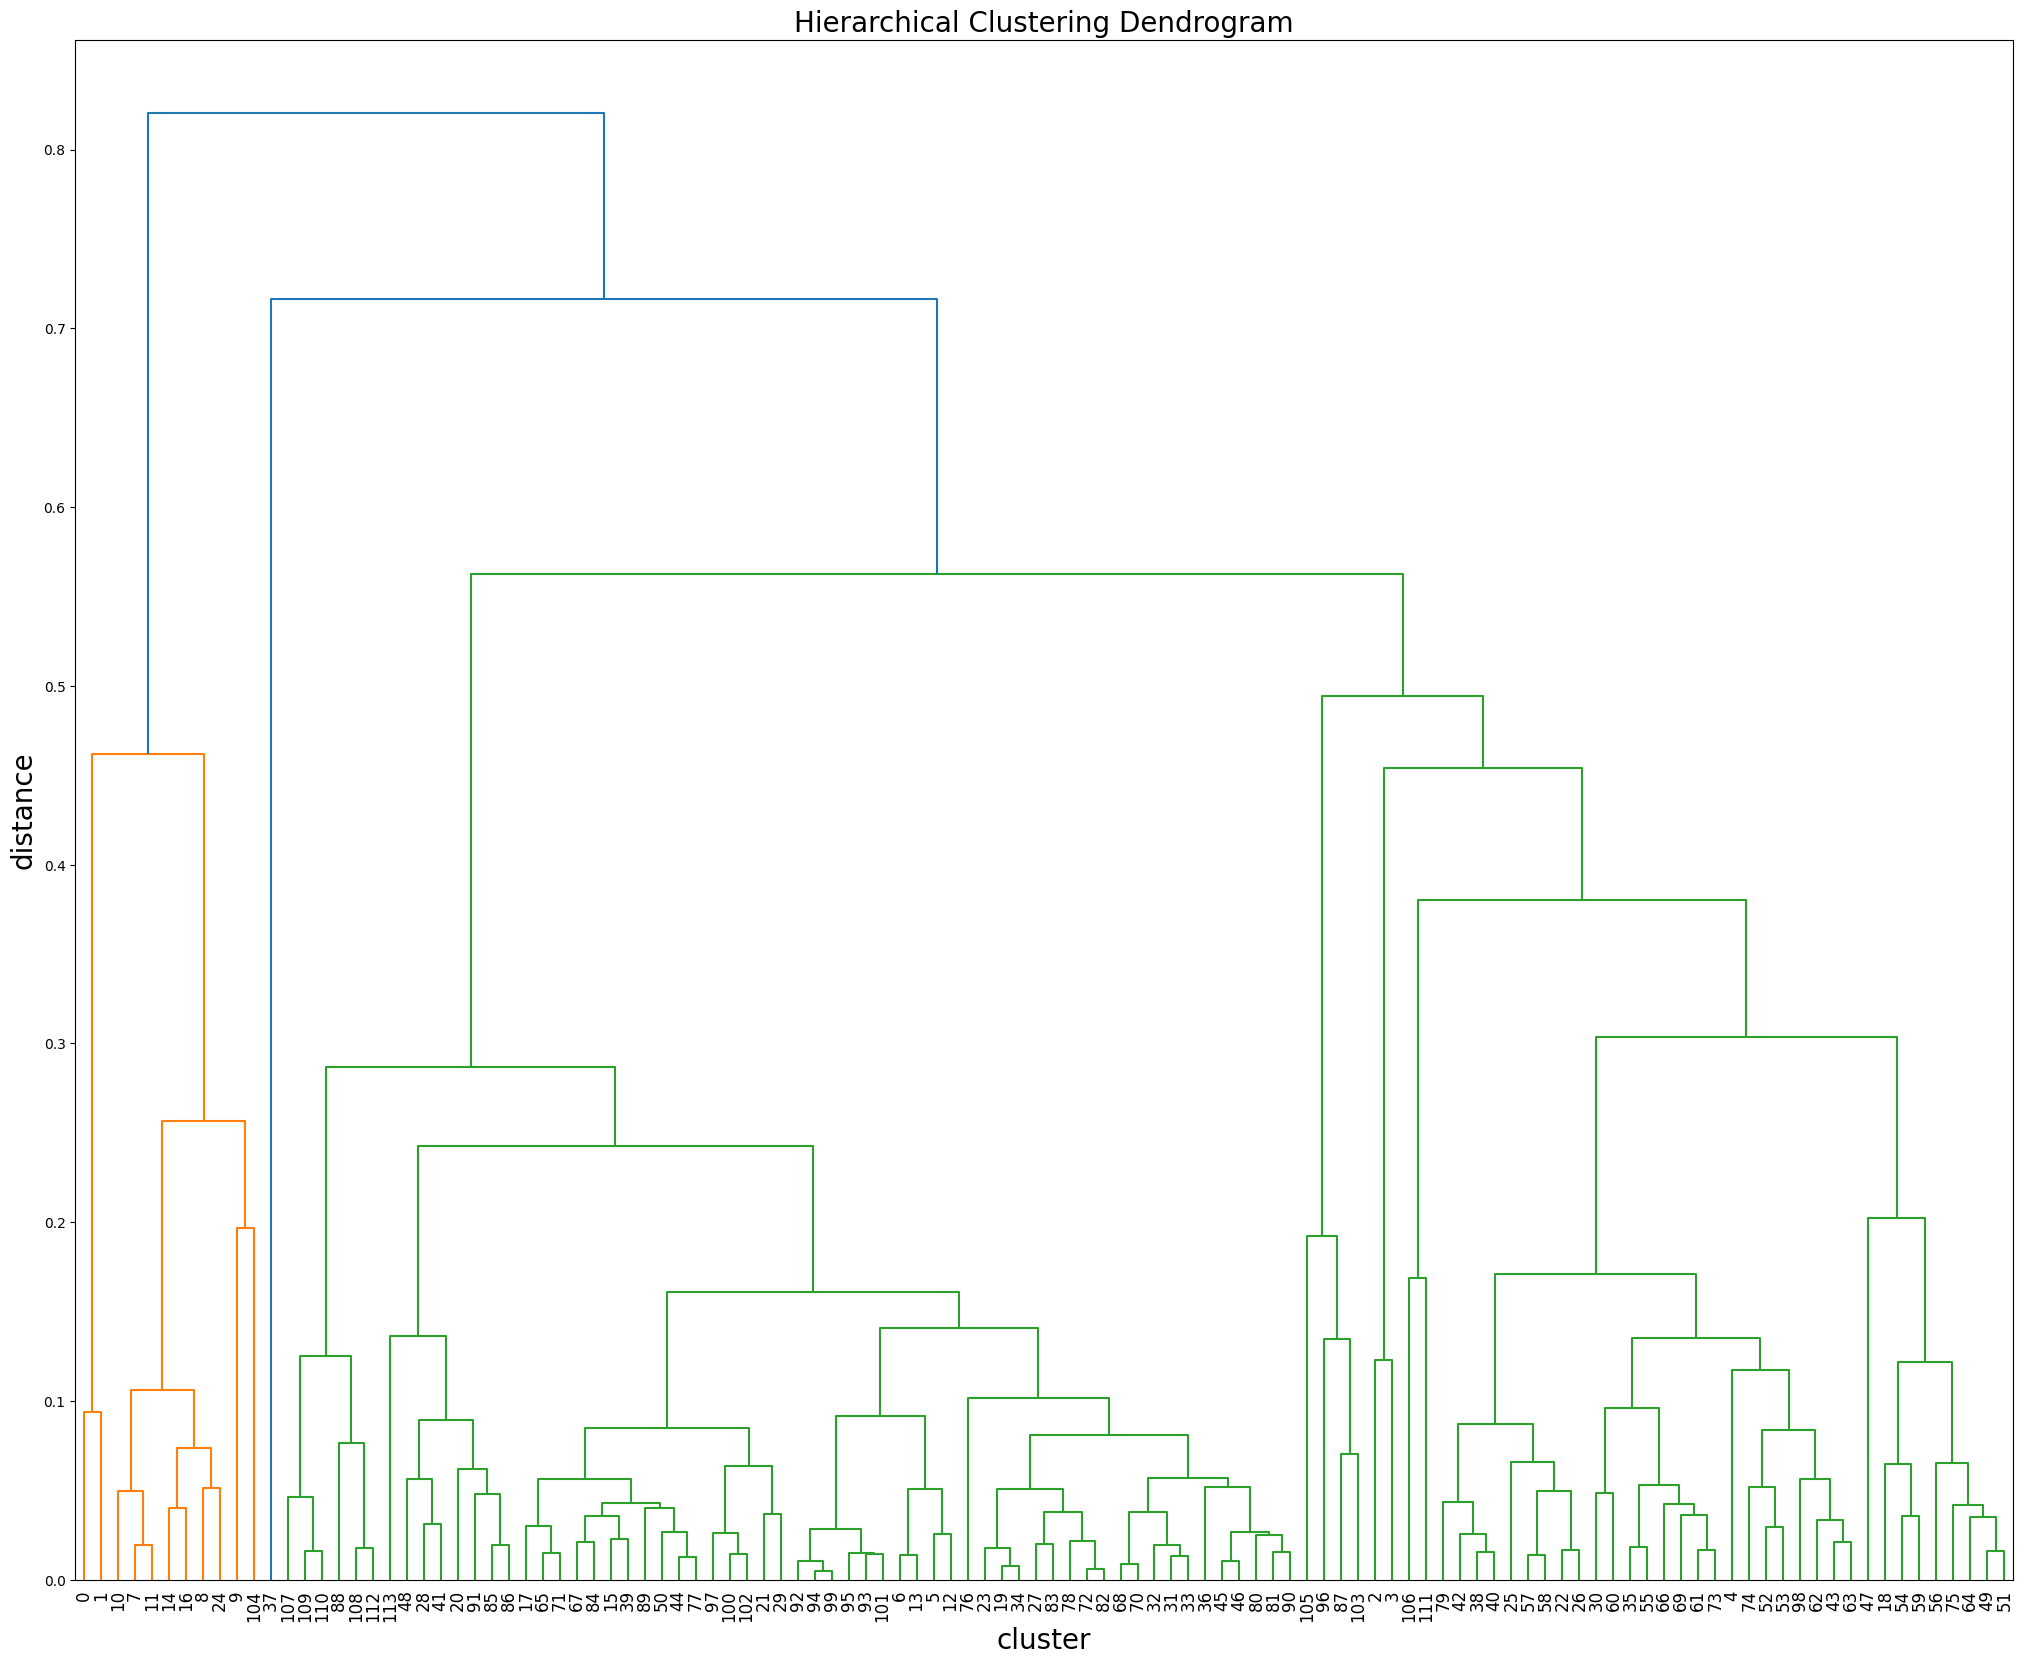

In [350]:
# Custom distance function parameters
coord_weight = 0.4
# coord_weight = 0
similarity_weight = 1-coord_weight
print(f'coord_weight: {coord_weight}, similarity_weight: {similarity_weight}')

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Calculate linkage matrix using custom distance function
# The custom distance function is a weighted average of the haversine distance between coordinates and 
# the similarity between the stop counts
linkage_matrix = linkage(data, method='complete', 
                         metric=lambda x, y: custom_distance(x, y, coord_weight, similarity_weight,min_distance,
                                                             max_distance,min_euclidean_distance,
                                                             max_euclidean_distance))



# calculate full dendrogram
plt.figure(figsize=(25, 20))
plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
plt.xlabel('cluster', fontsize=20)
plt.ylabel('distance', fontsize=20)
# Create a dendrogram for visualization purposes 
dendrogram(linkage_matrix, #truncate_mode='lastp', #p=12, 
           #orientation="right",
           leaf_rotation=90., leaf_font_size=12.)#, show_contracted=True)
plt.show()

In [351]:
#df_stop_count[(df_stop_count['FERMATA']==5103) | (df_stop_count['FERMATA']==-2)]
#stop 1: 5103.0, stop2: -2.0, combined_distance: 36.09851949056943

In [352]:
# 5097 torcello
# 5072 verso chioggia 
# -2 piazzale roma

#dataset_time_slots[dataset_time_slots['FERMATA'] == -5]

### threshold

In [353]:
# Determine clusters based on a desired threshold or number of clusters
threshold = 0.1
# threshold = 0.15
clusters = fcluster(linkage_matrix, t=threshold, criterion='distance', depth=2, R=None, monocrit=None)
# print(clusters)

In [354]:
#min_hd = min(haversine_distance_arr)
#max_hd = max(haversine_distance_arr)
#avg_hd = np.average(haversine_distance_arr)

#min_ed = min(eu_similarity_arr)
#max_ed = max(eu_similarity_arr)
#avg_ed = np.average(eu_similarity_arr)

#print(f'min_hd: {min_hd}, max_hd: {max_hd}, avg_hd: {avg_hd}')
#print(f'min_ed: {min_ed}, max_ed: {max_ed}, avg_ed: {avg_ed}')

In [355]:
#print(0.7*0.16)
#print(0.3*0.23)

In [356]:
# Adding cluster labels to the stop count dataframe
df_stop_count['CLUSTER'] = clusters
print(df_stop_count.shape)
df_stop_count.head()

(114, 8)


TICKET_CODE,LATITUDE,LONGITUDE,FERMATA,DESCRIZIONE,LOC,STUD,TUR,CLUSTER
0,45.223690,12.280678,5072,Chioggia,66.904479,7.768530,25.326992,1
1,45.262791,12.299958,5073,Pellestrina,73.255814,6.976744,19.767442,1
2,45.332737,12.316975,5102,S. Maria del,18.181818,0.000000,81.818182,17
3,45.341526,12.308979,5103,Alberoni Far,36.046512,0.000000,63.953488,18
4,45.390778,12.353001,-5,Lido bus,29.296389,4.234122,66.469489,24


In [357]:
#df_stop_count[df_stop_count['CLUSTER']==3]

In [358]:
cols_cl = ['FERMATA','CLUSTER']
df_cl = df_stop_count.copy()
df_cl = df_cl[cols_cl]

dataset_compl = dataset_compl.merge(df_cl, on=['FERMATA'])

df_sum_validations = dataset_compl.copy()
df_sum_validations = dataset_compl.groupby(['CLUSTER']).size().reset_index()
df_sum_validations.rename(columns={0: 'n_V'},inplace=True)
df_sum_validations.head(3)

,CLUSTER,n_V
0,1,5720
1,2,102415
2,3,49269


In [359]:
if 'DESCRIZIONE' not in df_stop_count.columns :
    df_stop_count = df_stop_count.merge(fermate, on=['LATITUDE','LONGITUDE','FERMATA'])
#df_stop_count

In [360]:
# get hex codes of tab_20 palette in the format 1:hex_code dict
cluster_colors = dict(zip(range(1,51), sns.color_palette("tab20", 50).as_hex()))
#cluster_colors

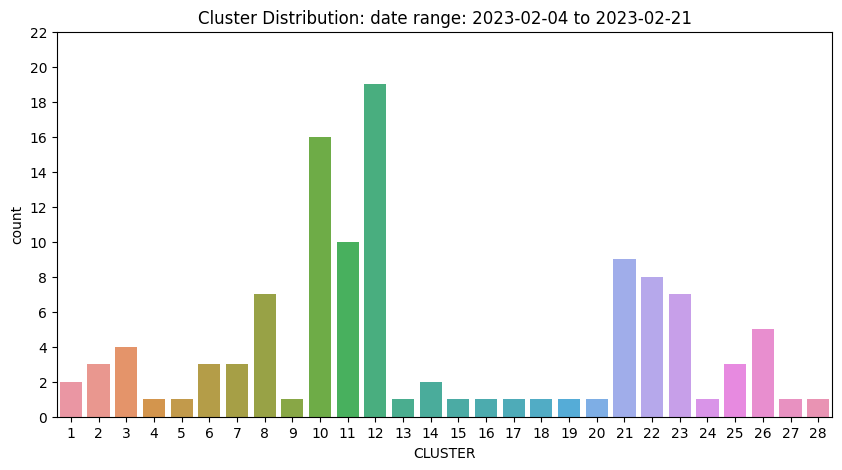

In [361]:
# Countplot of cluster distribution 
fig = plt.figure(figsize=(10, 5))
sns.countplot(x='CLUSTER', data=df_stop_count)#, palette=cluster_colors)
plt.yticks(np.arange(0, max(df_stop_count['CLUSTER'].value_counts()) + 5, 2))
plt.title('Cluster Distribution: ' + 'date range: ' + str(df_stop['DATA'].min().date()) + ' to ' 
          + str(df_stop['DATA'].max().date()))
plt.show()

In [362]:
grouped = df_stop_count.copy()
cols_grouped = ['CLUSTER', 'LOC', 'STUD', 'TUR']
grouped = grouped[cols_grouped]
grouped.reset_index(inplace=True,drop=True)
grouped = grouped.rename_axis(None, axis=1)

In [363]:
grouped_mean = grouped.groupby(['CLUSTER']).mean()
grouped_mean.reset_index(inplace=True)
grouped_mean

,CLUSTER,LOC,STUD,TUR
0,1,70.080146,7.372637,22.547217
1,2,67.991054,12.895619,19.113327
2,3,59.829695,11.032138,29.138167
3,4,100.000000,0.000000,0.000000
4,5,83.333333,0.000000,16.666667
5,6,10.362157,1.712704,87.925138
6,7,1.259065,0.212540,98.528395
7,8,18.661910,5.829787,75.508304
8,9,16.966581,5.325009,77.708410
9,10,11.712081,2.368949,85.918970


In [364]:
# è la standard deviation: se vuoi la varianza togli sqrt
grouped_var = grouped.groupby(['CLUSTER']).apply(lambda x: np.sqrt(np.var(x)))
grouped_var.drop(columns=['CLUSTER'],inplace = True)
grouped_var.reset_index(inplace=True)

In [365]:
grouped = grouped_mean.merge(grouped_var, on=['CLUSTER'])
grouped = grouped.fillna(0)

In [366]:
grouped = grouped.round(decimals = 3)
grouped

,CLUSTER,LOC_x,STUD_x,TUR_x,LOC_y,STUD_y,TUR_y
0,1,70.080,7.373,22.547,3.176,0.396,2.780
1,2,67.991,12.896,19.113,0.731,2.900,3.630
2,3,59.830,11.032,29.138,3.818,2.767,2.569
3,4,100.000,0.000,0.000,0.000,0.000,0.000
4,5,83.333,0.000,16.667,0.000,0.000,0.000
5,6,10.362,1.713,87.925,2.471,0.281,2.699
6,7,1.259,0.213,98.528,1.089,0.301,1.368
7,8,18.662,5.830,75.508,1.615,3.626,3.234
8,9,16.967,5.325,77.708,0.000,0.000,0.000
9,10,11.712,2.369,85.919,1.713,1.442,2.276


In [367]:
# List of ticket codes: 1, 2, 3, 4, 7, LOC, RET, STUD, WKRS
list_tc = ['LOC', 'STUD', 'TUR']
for i in list_tc:
    col_mean = str(i) + '_x'
    col_var = str(i) + '_y'
    col_ts = 'Mean_Var_' + str(i)
    grouped[col_ts] = grouped[col_mean].astype(str) + ' ± ' + grouped[col_var].apply(lambda x: f'{x:.2f}')

In [368]:
# See all columns of the dataframe
pd.set_option('display.max_columns', None)

In [369]:
print(grouped.shape)
grouped.head()

(28, 10)


,CLUSTER,LOC_x,STUD_x,TUR_x,LOC_y,STUD_y,TUR_y,Mean_Var_LOC,Mean_Var_STUD,Mean_Var_TUR
0,1,70.080,7.373,22.547,3.176,0.396,2.780,70.08 ± 3.18,7.373 ± 0.40,22.547 ± 2.78
1,2,67.991,12.896,19.113,0.731,2.900,3.630,67.991 ± 0.73,12.896 ± 2.90,19.113 ± 3.63
2,3,59.830,11.032,29.138,3.818,2.767,2.569,59.83 ± 3.82,11.032 ± 2.77,29.138 ± 2.57
3,4,100.000,0.000,0.000,0.000,0.000,0.000,100.0 ± 0.00,0.0 ± 0.00,0.0 ± 0.00
4,5,83.333,0.000,16.667,0.000,0.000,0.000,83.333 ± 0.00,0.0 ± 0.00,16.667 ± 0.00


In [370]:
cl_final = ['CLUSTER','Mean_Var_LOC','Mean_Var_STUD','Mean_Var_TUR']
grouped = grouped[cl_final]
grouped = grouped.merge(df_sum_validations, on=['CLUSTER'])

In [371]:
# Group by CLUSTER and aggregate the 'DESCRIZIONE' column into a list
clustered_stops = df_stop_count.groupby('CLUSTER')['DESCRIZIONE'].agg(['count', list]).reset_index()
clustered_stops = clustered_stops.merge(grouped, on = ['CLUSTER'])
#for i in range(6) : 
#    clustered_stops[i] = clustered_stops[i].round(decimals = 3)
#clustered_stops.sort_values(by=[0,1,2,3,4,5])
clustered_stops.rename(columns={'count': 'n_F', 'list': 'STOPS'},inplace=True)
clustered_cols = ['CLUSTER', 'n_F', 'n_V', 'Mean_Var_LOC', 'Mean_Var_STUD', 'Mean_Var_TUR', 'STOPS']

clustered_stops = clustered_stops[clustered_cols]
clustered_stops

,CLUSTER,n_F,n_V,Mean_Var_LOC,Mean_Var_STUD,Mean_Var_TUR,STOPS
0,1,2,5720,70.08 ± 3.18,7.373 ± 0.40,22.547 ± 2.78,"[Chioggia, Pellestrina ]"
1,2,3,102415,67.991 ± 0.73,12.896 ± 2.90,19.113 ± 3.63,"[Lido S.M.E. , Lido S.M.E. , Lido S.M.E. ]"
2,3,4,49269,59.83 ± 3.82,11.032 ± 2.77,29.138 ± 2.57,"[Lido S.M.E. , S.Elena-Stad, Lido S. Nico, Gia..."
3,4,1,10,100.0 ± 0.00,0.0 ± 0.00,0.0 ± 0.00,[Lido S.M.E. ]
4,5,1,78,83.333 ± 0.00,0.0 ± 0.00,16.667 ± 0.00,[S. Erasmo Pu]
5,6,3,83595,10.362 ± 2.47,1.713 ± 0.28,87.925 ± 2.70,"[Burano ""C"", Burano ""A"", Mazzorbo]"
6,7,3,1658,1.259 ± 1.09,0.213 ± 0.30,98.528 ± 1.37,"[Punta Sabbio, Burano ""B"", Torcello]"
7,8,7,13179,18.662 ± 1.61,5.83 ± 3.63,75.508 ± 3.23,"[Spirito Sant, Giardini ""B"", S. Marco-San, S. ..."
8,9,1,4209,16.967 ± 0.00,5.325 ± 0.00,77.708 ± 0.00,[Aeroporto]
9,10,16,64759,11.712 ± 1.71,2.369 ± 1.44,85.919 ± 2.28,"[Redentore, Zitelle ""B"", Giardini Bie, Certosa..."


In [372]:
# #df_stop_count[df_stop_count['CLUSTER']==21]
# grouped = df_stop_count.copy()
# cols_grouped = ['CLUSTER', '1', '2', '3', '4', '7', 'LOC', 'RET', 'STUD', 'WKRS']
# grouped = grouped[cols_grouped]
# grouped.reset_index(inplace=True,drop=True)
# grouped = grouped.rename_axis(None, axis=1)
# #grouped

# grouped_mean = grouped.groupby(['CLUSTER']).mean()
# grouped_mean.reset_index(inplace=True)
# grouped_mean

# # è la standard deviation: se vuoi la varianza togli sqrt
# grouped_var = grouped.groupby(['CLUSTER']).apply(lambda x: np.sqrt(np.var(x)))
# grouped_var.drop(columns=['CLUSTER'],inplace = True)
# grouped_var.reset_index(inplace=True)

# grouped = grouped_mean.merge(grouped_var, on=['CLUSTER'])
# grouped = grouped.fillna(0)
# #grouped

# grouped = grouped.round(decimals = 3)
# grouped
# grouped

# for i in range(6) :  
#     col_mean = str(i) + '_x'
#     col_var = str(i) + '_y'
#     col_ts = 'Mean_Var_' + str(i)
#     grouped[col_ts] = grouped[col_mean].astype(str) + ' ± ' + grouped[col_var].apply(lambda x: f'{x:.2f}')

# cl_final = ['CLUSTER','Mean_Var_0','Mean_Var_1','Mean_Var_2','Mean_Var_3','Mean_Var_4','Mean_Var_5']
# grouped = grouped[cl_final]

# #grouped

# # Group by CLUSTER and aggregate the 'DESCRIZIONE' column into a list
# clustered_stops = df_stop_count.groupby('CLUSTER')['DESCRIZIONE'].agg(['count', list]).reset_index()
# clustered_stops = clustered_stops.merge(grouped, on = ['CLUSTER'])
# #for i in range(6) : 
# #    clustered_stops[i] = clustered_stops[i].round(decimals = 3)
# #clustered_stops.sort_values(by=[0,1,2,3,4,5])
# clustered_stops.rename(columns={'count': 'NUM', 'list': 'STOPS'},inplace=True)
# clustered_cols = ['CLUSTER', 'NUM', 'Mean_Var_0', 'Mean_Var_1', 'Mean_Var_2','Mean_Var_3', 'Mean_Var_4',
#                   'Mean_Var_5','STOPS']
# clustered_stops = clustered_stops[clustered_cols]
# clustered_stops

In [373]:
# Create a folium map centered around the mean latitude and longitude
center_lat = np.mean(df_stop_count['LATITUDE'])
center_lon = np.mean(df_stop_count['LONGITUDE'])
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Create markers for each stop and color them based on clusters
for idx, row in df_stop_count.iterrows():
    # Retrieve Cluster id and set it as a integer
    cluster = int(row['CLUSTER'])

    cluster_color = cluster_colors.get(cluster, 'gray')  # Default to gray if cluster color is not defined
    #print(cluster_color)

    # cluster_color = cluster_
    # colors.get(cluster, 'gray')  # Default to gray if cluster color is not defined
    # Add a label to the marker with the name of the stop contained in the column 'DESCRIZIONE'
    # Retrieve the name of the stop from the column 'DESCRIZIONE' of the dataframe df matching the FERMATA
    location = df_stop_count[df_stop_count['FERMATA'] == row['FERMATA']]['DESCRIZIONE'].values[0]
    # Retrieve FERMATA id and set it as a integer
    fermata = int(row['FERMATA'])
    # Retrieve the total number of validations for the stop
    tot_validations = clustered_stops.loc[clustered_stops['CLUSTER'] == cluster, 'n_V'].iloc[0]
    # Retrieve the total number of stops for the stop
    tot_stops = clustered_stops.loc[clustered_stops['CLUSTER'] == cluster, 'n_F'].iloc[0]
    # Retrieve Cluster id and set it as a integer
    cluster = int(row['CLUSTER'])
    mean_loc = clustered_stops.loc[clustered_stops['CLUSTER'] == cluster, 'Mean_Var_LOC'].iloc[0]
    mean_stud = clustered_stops.loc[clustered_stops['CLUSTER'] == cluster, 'Mean_Var_STUD'].iloc[0]
    mean_tur = clustered_stops.loc[clustered_stops['CLUSTER'] == cluster, 'Mean_Var_TUR'].iloc[0]
    # Create a string for popup message containing the name of the stop, FERMATA and the cluster in BOLD
    #popup_message = f"<b><i>{location}</i></b><br><br><u>Fermata:</u> {fermata}<br><u>Cluster:</u> {cluster}<br><u>Mean and sd:</u> {mean_0}<br>"
    popup=folium.Popup(f"<b><i>{location}</i></b><br><br><u>Fermata:</u> {fermata}<br><u>Cluster:</u> {cluster}<br><u>Tot stops:</u> {tot_stops}<br><u>Tot validations:</u> {tot_validations}<br><u>Mean and sd:</u> <i>Mean LOC:</i> {mean_loc}<br><i>Mean STUD:</i> {mean_stud}<br><i>Mean TUR:</i> {mean_tur}<br>", max_width=300)


    # Add a marker to the map with the popup message and the color of the cluster
    # folium.Marker(location=[row['LATITUDE'], row['LONGITUDE']], popup=popup_message, icon=folium.Icon(color=cluster_color)).add_to(m)
    # Add a marker to the map with the popup message and the color of the cluster
    # folium.Marker(location=[row['LATITUDE'], row['LONGITUDE']], popup=popup_message, icon=folium.Icon(color=cluster_color)).add_to(m)
    if fermata < 0:
        folium.Marker(location=[row['LATITUDE'], row['LONGITUDE']], popup=popup, 
                      icon=folium.Icon(color='white', icon_color=cluster_color, icon='bus', prefix='fa')).add_to(m)
    else:
        folium.Marker(location=[row['LATITUDE'], row['LONGITUDE']], popup=popup, 
                      icon=folium.Icon(color='white', icon_color=cluster_color, icon='ship', prefix='fa')).add_to(m)

# Add layer control and show map
#m.add_child(folium.LayerControl(collapsed=False))
m

In [374]:
# print the number of unique values of the column 'FERMATA'
print('Number of unique values of the column FERMATA: {}'.format(df_stop_count['FERMATA'].nunique()))
# print the numer of clusters
print('Number of clusters: {}'.format(df_stop_count['CLUSTER'].nunique()))
# Print the average number of stops per cluster
print('Average number of stops per cluster: {}'.format(df_stop_count['CLUSTER'].value_counts().mean()))

Number of unique values of the column FERMATA: 114
Number of clusters: 28
Average number of stops per cluster: 4.071428571428571


In [375]:
df_stop_count.head()

TICKET_CODE,LATITUDE,LONGITUDE,FERMATA,DESCRIZIONE,LOC,STUD,TUR,CLUSTER
0,45.223690,12.280678,5072,Chioggia,66.904479,7.768530,25.326992,1
1,45.262791,12.299958,5073,Pellestrina,73.255814,6.976744,19.767442,1
2,45.332737,12.316975,5102,S. Maria del,18.181818,0.000000,81.818182,17
3,45.341526,12.308979,5103,Alberoni Far,36.046512,0.000000,63.953488,18
4,45.390778,12.353001,-5,Lido bus,29.296389,4.234122,66.469489,24


In [376]:
import plotly.graph_objects as go
import plotly.express as pex

source_indices = [df_stop_count[df_stop_count['FERMATA'] == row['FERMATA']].index[0] for idx, row in df_stop_count.iterrows()]
target_indices = [df_stop_count[df_stop_count['CLUSTER'] == row['CLUSTER']].index[0] for idx, row in df_stop_count.iterrows()]


sorted_clusters = sorted(df_stop_count['CLUSTER'].unique())
cluster_index_mapping = {cluster: index for index, cluster in enumerate(sorted_clusters)}
target_indices = [cluster_index_mapping[row['CLUSTER']] for idx, row in df_stop_count.iterrows()]


colors = pex.colors.qualitative.D3 ## Color Pallete

node_colors_mappings = dict([(node, np.random.choice(colors)) for node in df_stop_count['CLUSTER']])

node_colors = [node_colors_mappings[node] for node in df_stop_count['CLUSTER']]
edge_colors = [node_colors_mappings[node] for node in df_stop_count['CLUSTER']]

plt.figure(figsize=(20, 40))
# Sankey diagram ORDERED BY CLUSTER
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = sorted_clusters,
        color = node_colors
    ),
    link = dict(
        source = source_indices,
        target = target_indices,
        value = df_stop_count['FERMATA'],
        color = edge_colors
    ))])


fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)

# get the image more readable
fig.update_layout(width=1000, height=2000)

# Add information about the number of stops and the number of validations
fig.update_layout(title_text="Sankey Diagram: " + 'date range: ' + str(df_stop['DATA'].min().date()) + ' to '
                    + str(df_stop['DATA'].max().date()) + '<br>' + 'Number of stops: ' + str(df_stop_count['FERMATA'].nunique()) + '<br>' + 'Number of clusters: ' + str(df_stop_count['CLUSTER'].nunique()) + '<br>' + 'Average number of stops per cluster: ' + str(df_stop_count['CLUSTER'].value_counts().mean()) + '<br>' + 'Average number of validations per cluster: ' + str(df_stop_count['CLUSTER'].value_counts().mean()), font_size=10)

fig.show()


<Figure size 2000x4000 with 0 Axes>

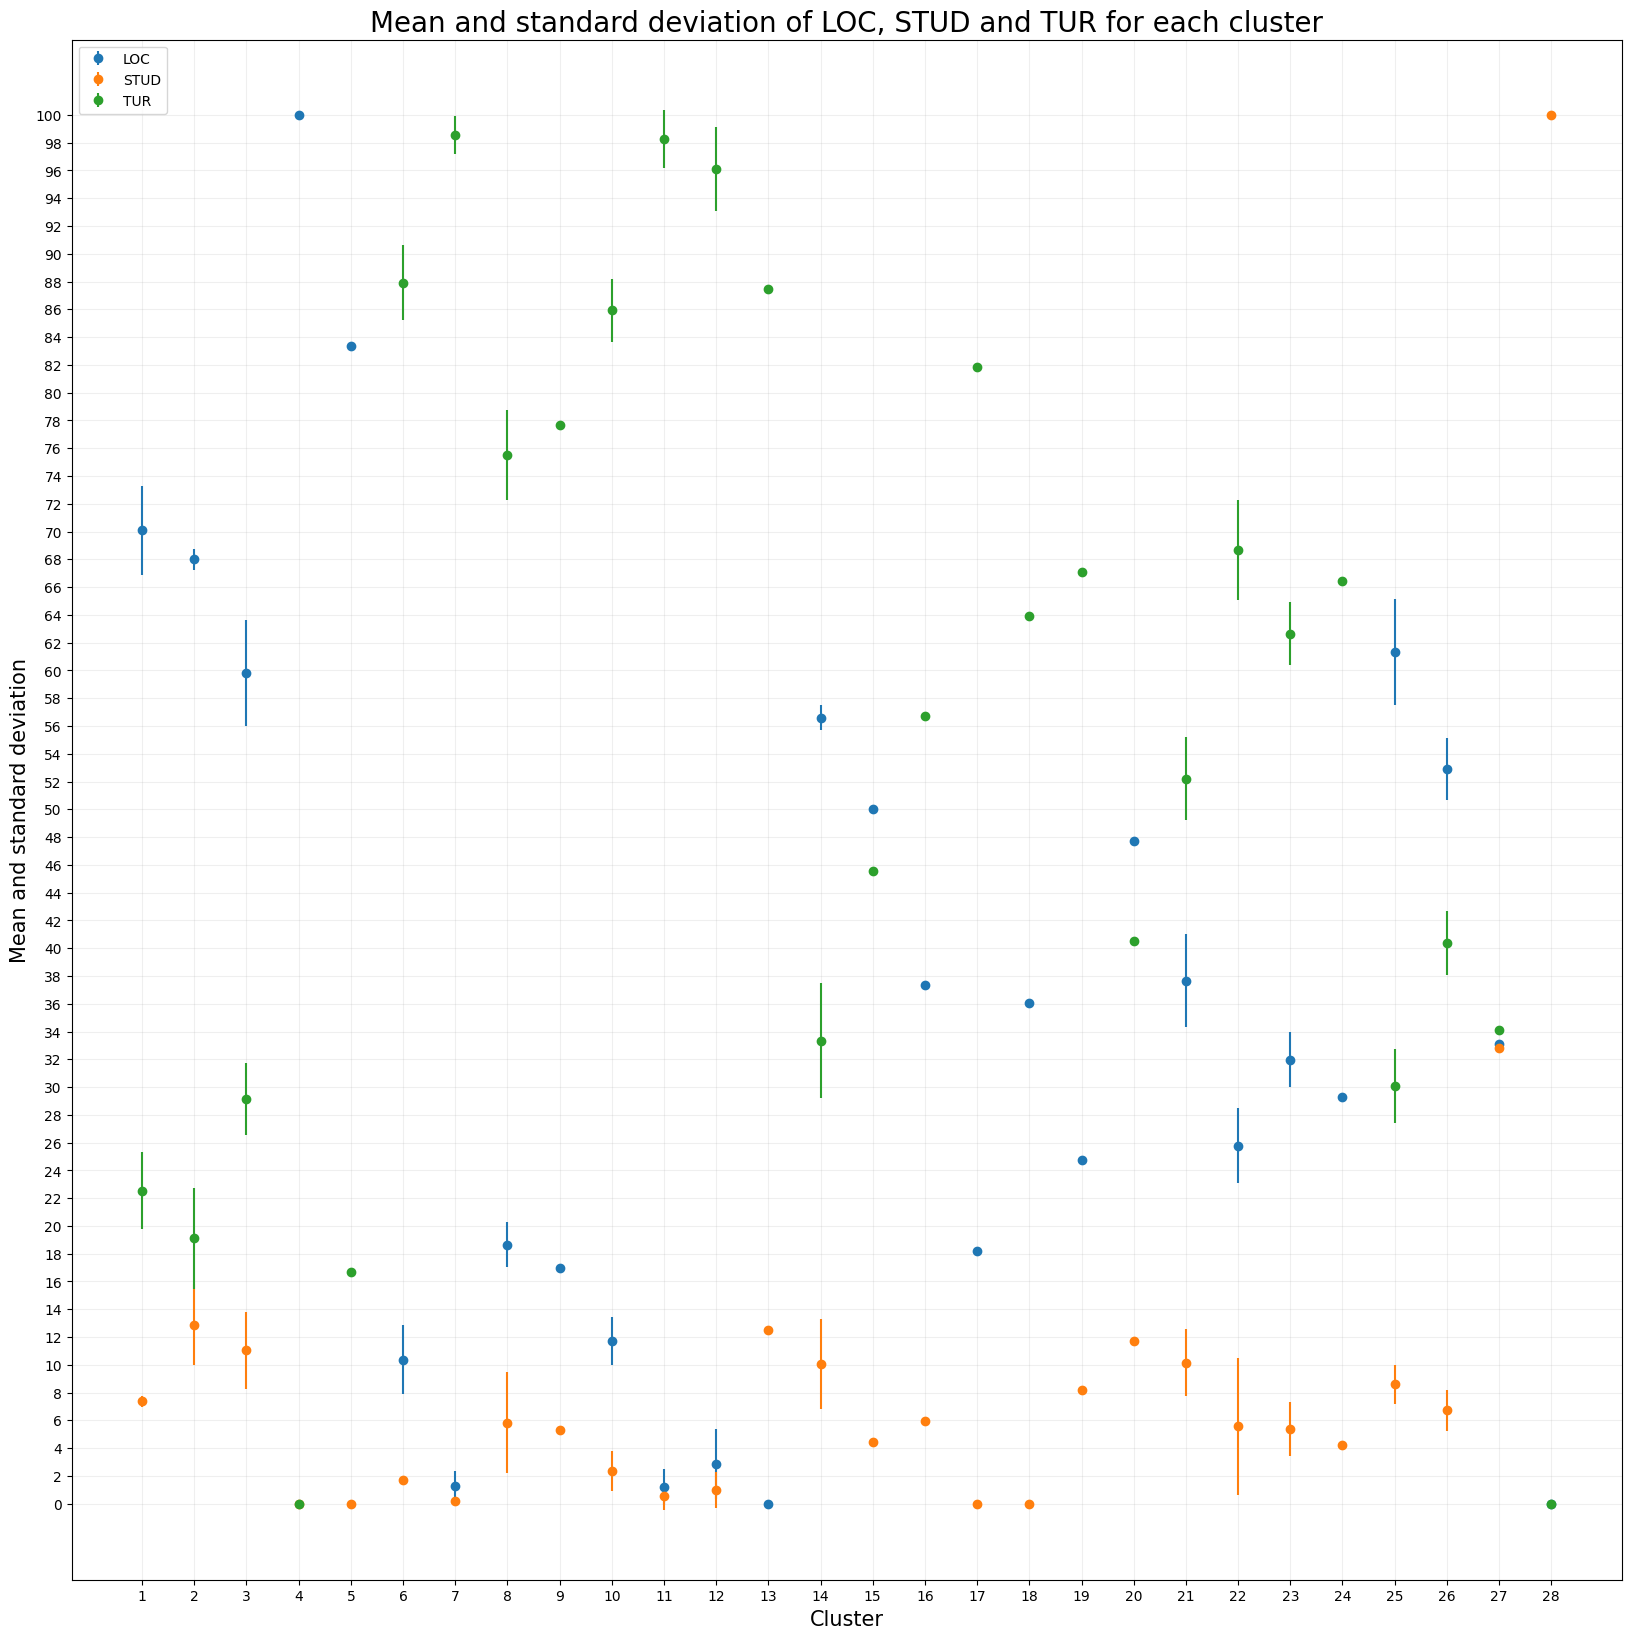

The diagram shows the average and the standard deviation of LOC, STUD and TUR for each cluster
The average and the standard deviation of LOC, STUD and TUR are calculated on the percentage of validations for each ticket code


In [378]:
# Represent in a diagram the average and the standard deviation of LOC, STUD and TUR for each cluster
# Create a dataframe with the columns 'CLUSTER', 'Mean_LOC', 'Mean_STUD', 'Mean_TUR', 'Std_LOC', 'Std_STUD', 'Std_TUR'
df_mean = grouped.copy()
df_mean_std = df_mean[['CLUSTER', 'Mean_Var_LOC', 'Mean_Var_STUD', 'Mean_Var_TUR']]
df_mean_std.rename(columns={'Mean_Var_LOC': 'Mean_LOC', 'Mean_Var_STUD': 'Mean_STUD', 'Mean_Var_TUR': 'Mean_TUR'}, inplace=True)
# Convert 'Mean_Var_LOC', 'Mean_Var_STUD', and 'Mean_Var_TUR' columns to float
# Extract and convert the Mean and Std from 'Mean_Var_LOC', 'Mean_Var_STUD', and 'Mean_Var_TUR' columns
df_mean_std['Std_LOC'] = grouped['Mean_Var_LOC'].apply(lambda x: float(x.split(' ± ')[1]))
df_mean_std['Std_STUD'] = grouped['Mean_Var_STUD'].apply(lambda x: float(x.split(' ± ')[1]))
df_mean_std['Std_TUR'] = grouped['Mean_Var_TUR'].apply(lambda x: float(x.split(' ± ')[1]))
df_mean_std['Mean_LOC'] = grouped['Mean_Var_LOC'].apply(lambda x: float(x.split(' ± ')[0]))
df_mean_std['Mean_STUD'] = grouped['Mean_Var_STUD'].apply(lambda x: float(x.split(' ± ')[0]))
df_mean_std['Mean_TUR'] = grouped['Mean_Var_TUR'].apply(lambda x: float(x.split(' ± ')[0]))



df_mean_std.head()

# Represent in a diagram the average and the standard deviation of LOC, STUD and TUR for each cluster
plt.figure(figsize=(20, 20))
plt.errorbar(df_mean_std['CLUSTER'], df_mean_std['Mean_LOC'], yerr=df_mean_std['Std_LOC'], fmt='o', label='LOC')
plt.errorbar(df_mean_std['CLUSTER'], df_mean_std['Mean_STUD'], yerr=df_mean_std['Std_STUD'], fmt='o', label='STUD')
plt.errorbar(df_mean_std['CLUSTER'], df_mean_std['Mean_TUR'], yerr=df_mean_std['Std_TUR'], fmt='o', label='TUR')
plt.xlabel('Cluster', fontsize=15)
plt.ylabel('Mean and standard deviation', fontsize=15)

# x-ticks from 1 to the number of clusters
plt.xticks(np.arange(1, df_mean_std['CLUSTER'].max() + 1, 1))

# y-ticks from 0 to 100
plt.yticks(np.arange(0, 102, 2))

# Add grid with opacity 0.4
plt.grid(alpha=0.2)

plt.title('Mean and standard deviation of LOC, STUD and TUR for each cluster', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# Print information about this diagram
print('The diagram shows the average and the standard deviation of LOC, STUD and TUR for each cluster')
print('The average and the standard deviation of LOC, STUD and TUR are calculated on the percentage of validations for each ticket code')

# How to read the diagram:
# The diagram shows the average and the standard deviation of LOC, STUD and TUR for each cluster
# The average and the standard deviation of LOC, STUD and TUR are calculated on the percentage of validations for each ticket code
# For example, for cluster 1, the average percentage of validations for LOC is 0.0% with a standard deviation of 0.0%
# the point is the average and the error bar is the standard deviation of the percentage of validations 


In [ ]:
# Export the map to an HTML file

th = str(threshold)
th = th.replace('.', '')
print(f'threshold: {th}')
num_cl = str(df_stop_count.CLUSTER.max())
print(f'number of clusters: {num_cl}')

file_name = 'finePrimavera'
dr_map = 'Documenti/risultati clustering/Nuovo_STUD-LOC-TUR/' + file_name + '/'
#time = datetime.now().strftime("%Y%m%d-%H%M%S")
try:
    m.save(dr+dr_map + file_name + '_threshold_' + th + '_' + num_cl + 'cluster' +'.html')
except:
    # Create a new folder in map folder
    os.mkdir(dr+dr_map + file_name)
    m.save(dr+dr_map + file_name + '_threshold_' + th + '_' + num_cl + 'cluster' +'.html')

In [ ]:
# For each Cluster id, print the number of stops in that cluster, the FERMATA id and the name of the stop
df_stop_count_copy = df_stop_count.copy()
# To df_stop_count add a column with the name of the stop matching the FERMATA
#df_stop_count_copy['DESCRIZIONE'] = df_stop_count_copy['FERMATA'].
#apply(lambda x: df[df['FERMATA'] == x]['DESCRIZIONE'].values[0])

# Consider only the columns ['Cluster', 'FERMATA', 'DESCRIZIONE']
df_stop_count_copy = df_stop_count_copy[['CLUSTER', 'FERMATA', 'DESCRIZIONE']]
df_stop_count_copy.columns.name = None

#df_stop_count_copy.groupby(['CLUSTER'])
#df_stop_count_copy = df_stop_count_copy.set_index(['CLUSTER','FERMATA'])
df_stop_count_copy


print('Number of clusters: ', max(df_stop_count_copy['CLUSTER']))
print('\n')
for cluster in range(1, max(df_stop_count_copy['CLUSTER']) + 1):
    print(f"CLUSTER {cluster} contains {len(df_stop_count_copy[df_stop_count_copy['CLUSTER'] == cluster])} stops.")
    print(df_stop_count_copy[df_stop_count_copy['CLUSTER'] == cluster][['FERMATA', 'DESCRIZIONE']])
    print('\n')

In [ ]:
#controlliamo un cluster 
df_stop_count[df_stop_count['CLUSTER']==6]

In [ ]:
#dataset_compl[dataset_compl['FERMATA']==5090]